<a href="https://colab.research.google.com/github/nachi-hebbar/ARIMA-Temperature_Forecasting/blob/master/Temperature_Forecast_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pmdarima

In [2]:
import pandas as pd
import numpy as np

#Read Data

In [3]:
df=pd.read_csv('MaunaLoaDailyTemps.csv',index_col='DATE',parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()

Shape of data (1821, 5)


,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758


#Plot Your Data

#Check For Stationarity

<Axes: xlabel='DATE'>

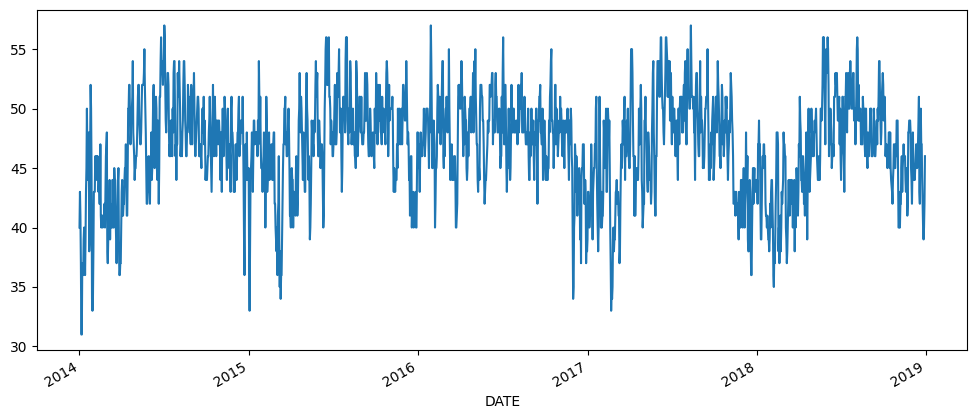

In [4]:
df['AvgTemp'].plot(figsize=(12,5))

<Axes: xlabel='DATE'>

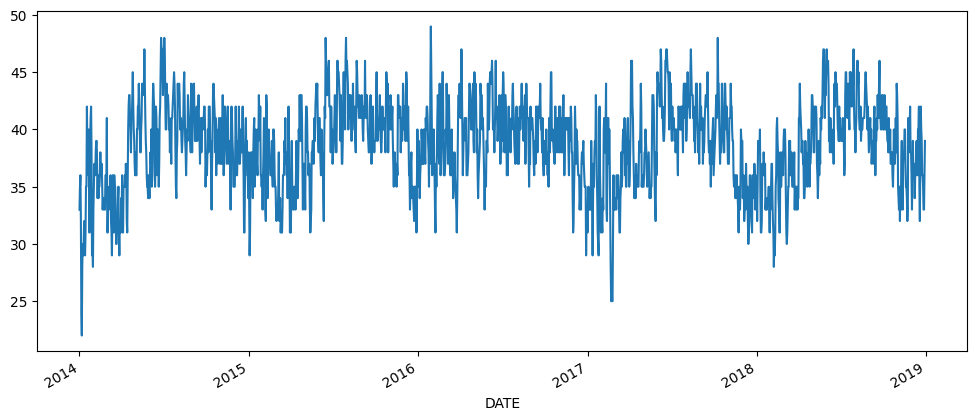

In [5]:
df['MinTemp'].plot(figsize=(12,5))

<Axes: xlabel='DATE'>

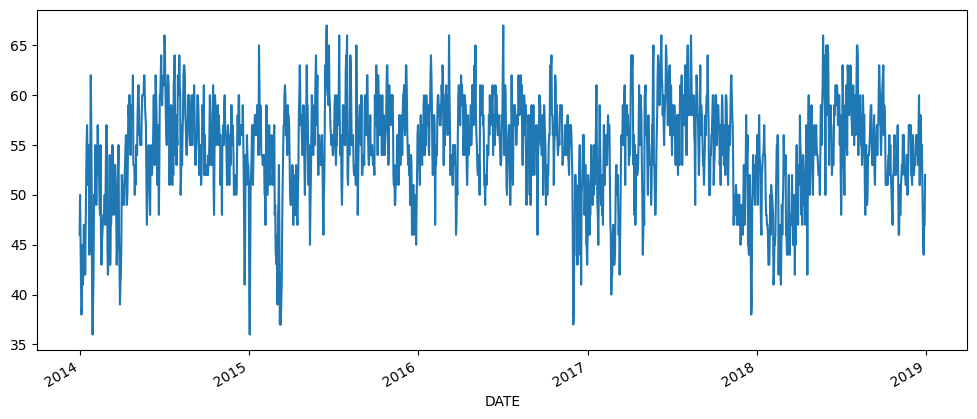

In [6]:
df['MaxTemp'].plot(figsize=(12,5))

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [8]:
adf_test(df['AvgTemp'])

1. ADF :  -6.554680125068785
2. P-Value :  8.675937480199322e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


#Figure Out Order for ARIMA Model

In [9]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
stepwise_fit = auto_arima(df['AvgTemp'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1821
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -4139.311
Date:                Fri, 29 Sep 2023   AIC                           8294.623
Time:                        19:51:54   BIC                           8338.680
Sample:                             0   HQIC                          8310.876
                               - 1821                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1474      0.345      3.326      0.001       0.471       1.824
ar.L1          0.9752      0.007    130.998      0.000       0.961       0.990
ma.L1         -0.1276      0.023     -5.461      0.000      -0.173      -0.082
ma.L2         -0.2238      0.024     -9.416      0.000      -0.270      -0.177
ma.L3         -0.2030      0.024     -8.597      0.000      -0.249      -0.157
ma.L4         -0.1395      0.023     -6.190      0.000      -0.184      -0.095
ma.L5         -0.0488      0.024     -2.020      0.043      -0.096      -0.001
sigma2         5.4499      0.169     32.237      0.000       5.119       5.781
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.89
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
from statsmodels.tsa.arima_model import ARIMA

#Split Data into Training and Testing

In [12]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1821, 5)
(1791, 5) (30, 5)
MinTemp      36.0
MaxTemp      52.0
AvgTemp      44.0
Sunrise     640.0
Sunset     1743.0
Name: 2018-12-01 00:00:00, dtype: float64 MinTemp      39.0
MaxTemp      52.0
AvgTemp      46.0
Sunrise     656.0
Sunset     1754.0
Name: 2018-12-30 00:00:00, dtype: float64


In [13]:
train.shape

(1791, 5)

## Train the Model

In [14]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
model = sm.tsa.ARIMA(train['AvgTemp'], order=(1, 0, 5))  # (p, d, q) order of the model
fitted_model = model.fit()
print(fitted_model.summary())



                               SARIMAX Results                                
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Fri, 29 Sep 2023   AIC                           8156.395
Time:                        19:51:56   BIC                           8200.320
Sample:                             0   HQIC                          8172.614
                               - 1791                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.0

#Make Predictions on Test Set

In [15]:
start=len(train)
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')
pred=fitted_model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=index_future_dates



In [22]:
print(start, end)

1791 1820


In [21]:
print(pred)

2023-03-30    46.418166
2023-03-31    46.113912
2023-04-01    45.617874
2023-04-02    45.249566
2023-04-03    45.116915
2023-04-04    45.136665
2023-04-05    45.156139
2023-04-06    45.175341
2023-04-07    45.194274
2023-04-08    45.212942
2023-04-09    45.231348
2023-04-10    45.249497
2023-04-11    45.267393
2023-04-12    45.285037
2023-04-13    45.302435
2023-04-14    45.319590
2023-04-15    45.336504
2023-04-16    45.353182
2023-04-17    45.369627
2023-04-18    45.385841
2023-04-19    45.401828
2023-04-20    45.417592
2023-04-21    45.433135
2023-04-22    45.448461
2023-04-23    45.463572
2023-04-24    45.478472
2023-04-25    45.493164
2023-04-26    45.507649
2023-04-27    45.521932
2023-04-28    45.536016
2023-04-29    45.549902
Freq: D, Name: ARIMA Predictions, dtype: float64


# accuracy test

In [16]:
test['AvgTemp'].mean()

45.0

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt




rmse = np.sqrt(mean_squared_error(test['AvgTemp'], pred))
print(rmse)
accuracy = (1 - rmse / test['AvgTemp'].mean()) * 100
print('Accuracy of ARIMA model for climate forecasting: {:.2f}%'.format(accuracy))


3.000463988750059
Accuracy of ARIMA model for climate forecasting: 93.33%


In [18]:
model2=sm.tsa.ARIMA(df['AvgTemp'],order=(1,0,5))
model2=model2.fit()
df.tail()

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2018-12-26,35.0,45.0,40.0,654,1752
2018-12-27,33.0,44.0,39.0,655,1752
2018-12-28,33.0,47.0,40.0,655,1753
2018-12-29,36.0,47.0,42.0,655,1753
2018-12-30,39.0,52.0,46.0,656,1754


#For Future Dates

In [36]:
len(df)

1821

In [24]:
index_future_dates=pd.date_range(start='2019-01-01',end='2019-01-31')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2019-01-01    46.418166
2019-01-02    46.113912
2019-01-03    45.617874
2019-01-04    45.249566
2019-01-05    45.116915
2019-01-06    45.136665
2019-01-07    45.156139
2019-01-08    45.175341
2019-01-09    45.194274
2019-01-10    45.212942
2019-01-11    45.231348
2019-01-12    45.249497
2019-01-13    45.267393
2019-01-14    45.285037
2019-01-15    45.302435
2019-01-16    45.319590
2019-01-17    45.336504
2019-01-18    45.353182
2019-01-19    45.369627
2019-01-20    45.385841
2019-01-21    45.401828
2019-01-22    45.417592
2019-01-23    45.433135
2019-01-24    45.448461
2019-01-25    45.463572
2019-01-26    45.478472
2019-01-27    45.493164
2019-01-28    45.507649
2019-01-29    45.521932
2019-01-30    45.536016
2019-01-31    45.549902
Freq: D, Name: ARIMA Predictions, dtype: float64


In [26]:
import matplotlib.pylab as plt

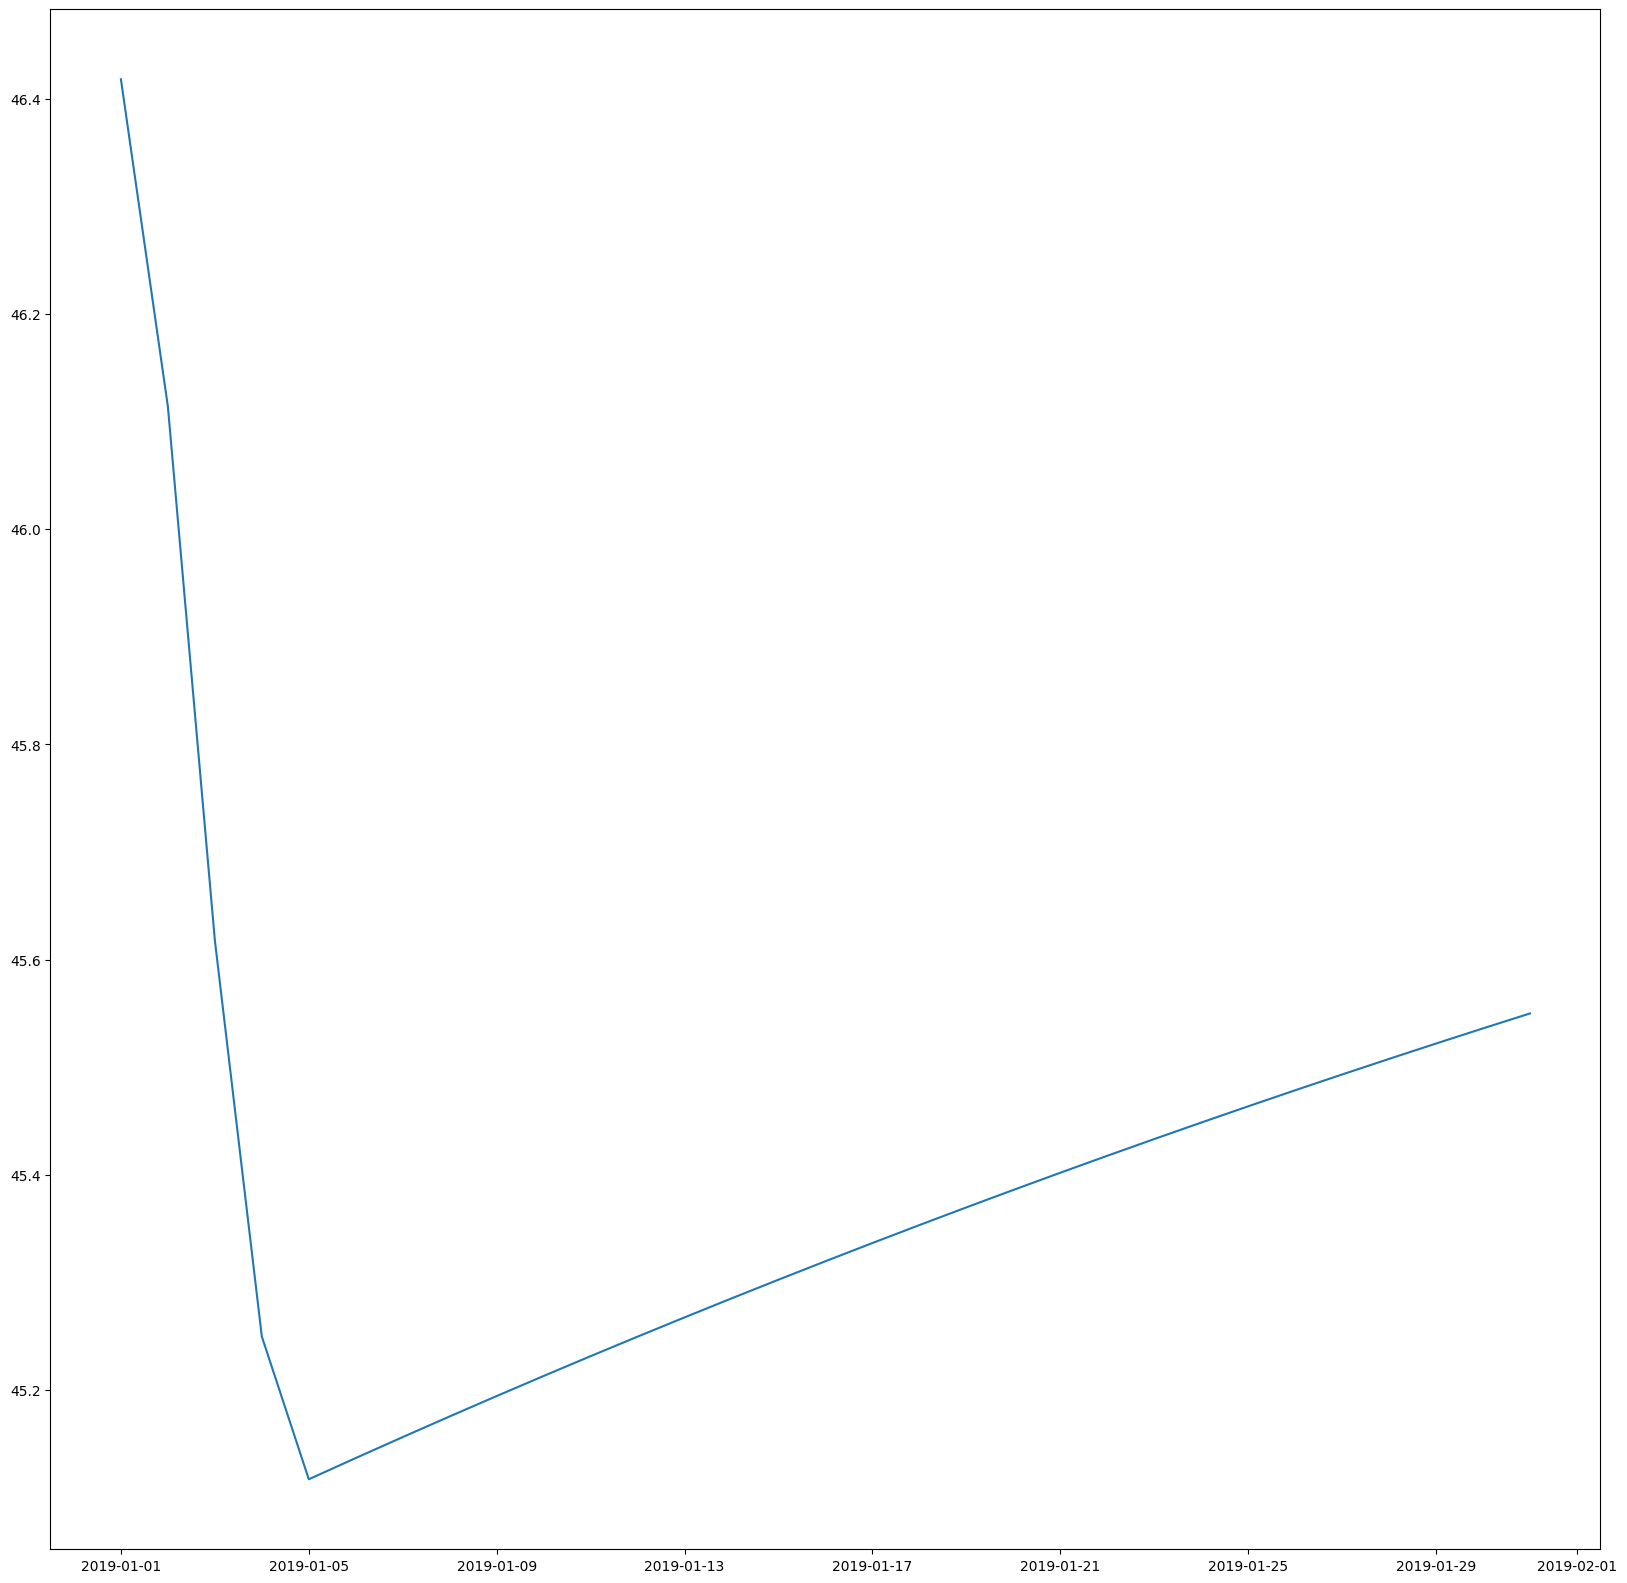

In [34]:
plt.figure(figsize=(20,20))
plt.plot(pred)

<Axes: >

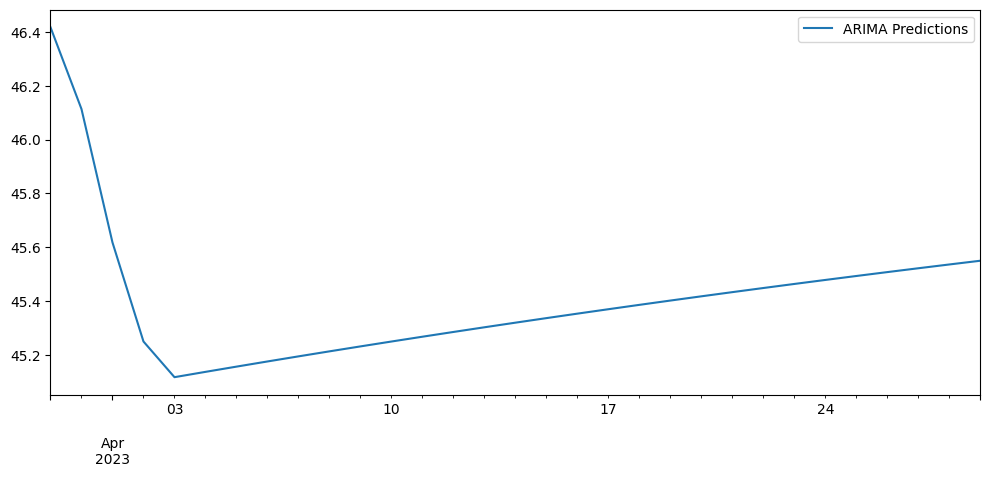

In [20]:
pred.plot(figsize=(12,5),legend=True)


In [35]:
import pickle

with open('model.pkl','wb') as file_obj:
    pickle.dump(model2,file_obj)